# Data science project in Python - Voorspellingen maken met features

Doormiddel van numpy, pandas, matplotlib & SciKit-learn

Door Louis D'Hont - Elektronica-ICT - 2021

Dit project is het tweede deel van het data science project

In [1]:
# Importeren van gebruikte bibliotheken
import datetime
import seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import plot_tree
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error

In [2]:
#features['Bestemming'].unique()

In [3]:
features = pd.read_csv("featuresDataFrame.csv", sep=',') 
features = features.drop(['Unnamed: 0'], axis=1)

nederland = ['friese', 'nederland', 'vlieland', 'brabant', 'twente', 'drenthe', 'limburg', 'brabantse', 'nederlands', 'duinen', 'salland', 'zeeland', 'ijslanders']
belgie = ['ardennen', 'belgium', 'ardenne', 'belgië', 'belgie', 'arrdennen', 'eifel', 'ardennen', 'ardenen']
frankrijk = ['frankrijk', 'mont saint michel', 'morvan', 'dartmoor', 'couleurs corse', 'vogezen', 'margeride', 'haute valee', 'jura', 'normandië', 'médoc', 'montmorillonnais', 'france', 'loire', 'wijnroute', 'wijngaarden', 'elzas', 'pyreneeën', 'dordogne', 'pyreneeen', 'corsica', 'aude', 'frans', 'armagnac', 'frankrijjk', 'frankijk']
duitsland = ['germany', 'duitsland', 'thuringen', 'beieren', 'duitsand', 'duitse', 'thüringen']
spanje = ['spain', 'spanje', 'sulayr', 'alpujarra', 'middellandse', 'demanda', 'monfrague', 'andalusisch', 'costa brava', 'sierra nevada', 'catalonië','catalonie', 'gredos', 'andalusië', 'ronda', 'andalusie', 'conquistadores']
italie = ['italy', 'italie', 'sicilië', 'madonie', 'italië', 'sardinië', 'sardinie', 'toscane', 'molise', 'alta maremma', 'molise abruzzen']
portugal = ['portugal', 'lusitano', 'faro', 'algarve', 'lissabon', 'portugese', 'azoren']
usa = ['verenigde staten', 'montana', 'usa', 'united states', 'wyoming', 'ranch', 'colorado']
kroatie = ['kroatie', 'croatia', 'kroatië', 'istrië', 'plitvice', 'rode-meer', 'dalmatie', 'istrie']
allerlei = ['Klassieke dressuur van topkwaliteit en stedenschoon', 'Avontuurlijke trektocht door een sprookjesachtig gebied', 'Trektocht in het spoor van de tuimelaar-dolfijn ',
       'Driedaagse trektocht in het land van d\x19Oc en d\x19Oil', 'Trektocht over de bergen naar de zee', 'Trektocht in het spoor van de tuimelaar-dolfijn','Paardrijden langs de route van de bandieten', 'De \x18Great Trek\x19: werkelijk avontuurlijke trektocht',
       'Beach and Bush Rides', 'Dressuurweek','Een week paardrijden met jongvolwassenen','National Park: paardrijden voor pure ontspanning',
       'Driedaagse tocht door de Vienne-vallei','Trektocht naar de gouden stranden', 'Oman','Trektocht tussen zee en woestijnbergen', 'Programma Full','Smokkelaarstocht', 'Trektocht over de bergen naar zee','Beach and Meadows trektocht','De "legendes van de Wolf"-trektocht','Standplaatsvakantie Stertochten', 'nan']

def convert_bestemmingen():
    for index, row in enumerate(features['Bestemming']):
        if any(ext in (str(row).lower()) for ext in belgie):
            features['Bestemming'].iloc[index] = 1
        elif any(ext in (str(row).lower()) for ext in nederland):
            features['Bestemming'].iloc[index] = 2
        elif any(ext in (str(row).lower()) for ext in frankrijk):
            features['Bestemming'].iloc[index] = 3
        elif any(ext in (str(row).lower()) for ext in duitsland):
            features['Bestemming'].iloc[index] = 4
        elif any(ext in (str(row).lower()) for ext in portugal):
            features['Bestemming'].iloc[index] = 5
        elif any(ext in (str(row).lower()) for ext in ['ijsland', 'iceland', 'geysir', 'golden circle']):
            features['Bestemming'].iloc[index] = 6
        elif any(ext in (str(row).lower()) for ext in italie):
            features['Bestemming'].iloc[index] = 7
        elif any(ext in (str(row).lower()) for ext in ['ierland', 'ireland', 'galway', 'ierse', 'donegal']):
            features['Bestemming'].iloc[index] = 8
        elif any(ext in (str(row).lower()) for ext in usa):
            features['Bestemming'].iloc[index] = 9
        elif any(ext in (str(row).lower()) for ext in ['jordanie', 'jordan', 'wadi rum']):
            features['Bestemming'].iloc[index] = 10
        elif any(ext in (str(row).lower()) for ext in spanje):
            features['Bestemming'].iloc[index] = 11
        elif any(ext in (str(row).lower()) for ext in ['botswana']):
            features['Bestemming'].iloc[index] = 12
        elif any(ext in (str(row).lower()) for ext in ['canada', 'yukon', 'alberta', 'saskatchewan']):
            features['Bestemming'].iloc[index] = 13
        elif any(ext in (str(row).lower()) for ext in ['roemenie', 'roemenië', 'transsylvanie', 'transsylvanië']):
            features['Bestemming'].iloc[index] = 14
        elif any(ext in (str(row).lower()) for ext in ['chili', 'chile']):
            features['Bestemming'].iloc[index] = 15
        elif any(ext in (str(row).lower()) for ext in ['marokko', 'marokkaanse', 'berbers']):
            features['Bestemming'].iloc[index] = 16
        elif any(ext in (str(row).lower()) for ext in ['griekenland', 'petra', 'kreta', 'kefalonia']):
            features['Bestemming'].iloc[index] = 17
        elif any(ext in (str(row).lower()) for ext in ['zuid afrika', 'afrika']):
            features['Bestemming'].iloc[index] = 18
        elif any(ext in (str(row).lower()) for ext in ['bulgarije', 'bulgaria', 'balkan']):
            features['Bestemming'].iloc[index] = 19
        elif any(ext in (str(row).lower()) for ext in ['hongarije', 'poesta', 'homgarije']):
            features['Bestemming'].iloc[index] = 20
        elif any(ext in (str(row).lower()) for ext in ['tsjechie', 'tsjechië', 'zuid-bohemen', 'karpaten']):
            features['Bestemming'].iloc[index] = 21   
        elif any(ext in (str(row).lower()) for ext in ['cappadocië', 'turkije', 'turklije', 'thracians']):
            features['Bestemming'].iloc[index] = 22
        elif any(ext in (str(row).lower()) for ext in ['polen', 'poolse', 'poland']):
            features['Bestemming'].iloc[index] = 23
        elif any(ext in (str(row).lower()) for ext in ['namibie', 'namibië']):
            features['Bestemming'].iloc[index] = 24
        elif any(ext in (str(row).lower()) for ext in ['kirgizie', 'kirgizië']):
            features['Bestemming'].iloc[index] = 25
        elif any(ext in (str(row).lower()) for ext in ['montenegro']):
            features['Bestemming'].iloc[index] = 26
        elif any(ext in (str(row).lower()) for ext in ['zweden']):
            features['Bestemming'].iloc[index] = 27
        elif any(ext in (str(row).lower()) for ext in ['albanie', 'albanië', 'katharen']):
            features['Bestemming'].iloc[index] = 28
        elif any(ext in (str(row).lower()) for ext in ['mongolië', 'mongolie', 'mongoolse']):
            features['Bestemming'].iloc[index] = 29
        elif any(ext in (str(row).lower()) for ext in kroatie):
            features['Bestemming'].iloc[index] = 30
        elif any(ext in (str(row).lower()) for ext in ['costa rica']):
            features['Bestemming'].iloc[index] = 31
        elif any(ext in (str(row).lower()) for ext in ['slowakije']):
            features['Bestemming'].iloc[index] = 32
        elif any(ext in (str(row).lower()) for ext in ['brazilie', 'santa catarina gaucho']):
            features['Bestemming'].iloc[index] = 33
        elif any(ext in (str(row).lower()) for ext in ['denemarken', 'denmark', 'deense']):
            features['Bestemming'].iloc[index] = 34
        elif any(ext in (str(row).lower()) for ext in ['noorwegen', 'norway', 'ramsjo-special', 'northern', 'scandinavische']):
            features['Bestemming'].iloc[index] = 35
        elif any(ext in (str(row).lower()) for ext in ['azerbidjan']):
            features['Bestemming'].iloc[index] = 36
        elif any(ext in (str(row).lower()) for ext in ['georgie', 'georgië', 'georgia']):
            features['Bestemming'].iloc[index] = 37
        elif any(ext in (str(row).lower()) for ext in ['zwitserland']):
            features['Bestemming'].iloc[index] = 38
        elif any(ext in (str(row).lower()) for ext in ['groot-brittanie', 'wales', 'britain', 'engeland']):
            features['Bestemming'].iloc[index] = 39
        elif any(ext in (str(row).lower()) for ext in ['argentinie', 'argentinië', 'noord-argentinië']):
            features['Bestemming'].iloc[index] = 40
        elif any(ext in (str(row).lower()) for ext in ['cuba']):
            features['Bestemming'].iloc[index] = 41
        elif any(ext in (str(row).lower()) for ext in ['lapland', 'finland']):
            features['Bestemming'].iloc[index] = 42
        elif any(ext in (str(row).lower()) for ext in ['mexico']):
            features['Bestemming'].iloc[index] = 43
        elif any(ext in (str(row).lower()) for ext in ['china']):
            features['Bestemming'].iloc[index] = 44
        elif any(ext in (str(row).lower()) for ext in ['kenia']):
            features['Bestemming'].iloc[index] = 45
        elif any(ext in (str(row).lower()) for ext in ['iran']):
            features['Bestemming'].iloc[index] = 46
        elif any(ext in (str(row).lower()) for ext in ['servië', 'servie', 'sumadija']):
            features['Bestemming'].iloc[index] = 47
        elif any(ext in (str(row).lower()) for ext in ['schotland']):
            features['Bestemming'].iloc[index] = 48
        elif any(ext in (str(row).lower()) for ext in ['egypte', 'sahara']):
            features['Bestemming'].iloc[index] = 49
        elif any(ext in (str(row).lower()) for ext in ['andorra']):
            features['Bestemming'].iloc[index] = 50
        elif any(ext in (str(row).lower()) for ext in ['uruguay']):
            features['Bestemming'].iloc[index] = 51
        elif any(ext in (str(row).lower()) for ext in ['rusland']):
            features['Bestemming'].iloc[index] = 52
        elif any(ext in (str(row).lower()) for ext in ['columbia', 'colombiaans']):
            features['Bestemming'].iloc[index] = 53
        elif any(ext in (str(row).lower()) for ext in ['australie']):
            features['Bestemming'].iloc[index] = 54
        elif any(ext in str(row) for ext in allerlei):
            features['Bestemming'].iloc[index] = 2
    return features['Bestemming'] 

features['Bestemming'] == convert_bestemmingen()
features['Bestemming'] = features['Bestemming'].astype(int)


/Users/louisdhont/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Omzetten van datatypes

De opgeslagen data is bij het inlezen opnieuw van het type int64, float64 en object. De data dat hiervoor een timedelta was ('Aantal dagen tot vertrek' en de 'Aantal dagen op reis' kolom) moet worden omgezet zodat er terug met kan worden gewerkt.

In [4]:
def convert_timedelta(df_col):
    for index, row in enumerate(df_col): 
        days, timestamp = row.split(" days ")
        df_col.iloc[index] = days
    return df_col

def convert_land(df_land):
    for index, row in enumerate(df_land):
        if row == 'be':
            df_land.iloc[index] = 1
        elif row == 'nl':
            df_land.iloc[index] = 2
        elif row == 'fr':
            df_land.iloc[index] = 3
        elif row == 'de':
            df_land.iloc[index] = 4
        elif row == 'gb':
            df_land.iloc[index] = 5  
        elif row == 'lux':
            df_land.iloc[index] = 6
        elif row == 'sco':
            df_land.iloc[index] = 7
        elif row == 'pt':
            df_land.iloc[index] = 8
        elif row == 'sco':
            df_land.iloc[index] = 9
        elif row == 'sr':
            df_land.iloc[index] = 10
        elif row == 'cn':
            df_land.iloc[index] = 11
        elif row == 'aut':
            df_land.iloc[index] = 12
        elif row == 'ca':
            df_land.iloc[index] = 13   
        elif row == 'it':
            df_land.iloc[index] = 14
        elif row == 'es':
            df_land.iloc[index] = 15
        elif row == 'cl':
            df_land.iloc[index] = 16

def convert_reis_type(df_reistype):
    for index, row in enumerate(df_reistype):
        if row == 'Ruitervakantie':
            df_reistype.iloc[index] = 1
        elif row == 'Ponykamp':
            df_reistype.iloc[index] = 2
        elif row == 'Ruitervakantie& Vliegreis':
            df_reistype.iloc[index] = 3
        elif row == 'Trektocht':
            df_reistype.iloc[index] = 4
        elif row == 'Ruitervakantie Eigen Vervoer':
            df_reistype.iloc[index] = 5  
        elif row == 'Huifkar tocht':
            df_reistype.iloc[index] = 6
        elif row == 'Safari':
            df_reistype.iloc[index] = 7
        elif row == 'Jeugdkamp':
            df_reistype.iloc[index] = 8
        elif row == 'Weekendje weg':
            df_reistype.iloc[index] = 9

features['Datum creatie'] = pd.to_datetime(features['Datum creatie'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
features['Datum vertrek'] = pd.to_datetime(features['Datum vertrek'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
features['Datum terug'] = pd.to_datetime(features['Datum terug'], format='%Y.%m.%d', infer_datetime_format=True, errors='coerce')
    
features['Aantal dagen tot vertrek'] == convert_timedelta(features['Aantal dagen tot vertrek'])
features['Aantal dagen tot vertrek'] = features['Aantal dagen tot vertrek'].astype(int)

features['Aantal dagen op reis'] == convert_timedelta(features['Aantal dagen op reis'])
features['Aantal dagen op reis'] = features['Aantal dagen op reis'].astype(int)
            
features['Land'] == convert_land(features['Land'])
features['Land'] = features['Land'].astype(int)

features['Reistype'] == convert_reis_type(features['Reistype'])
features['Reistype'] = features['Reistype'].astype(int)                                        

De onderstaande lijst toont voor elke kolom het datatype. Alle kolommen zijn omgezet naar int, float of datetime. De integer en float waarden kunnen worden gebruikt als feature.

In [5]:
features.dtypes

Status                               int64
Dossier jaar                         int64
Dossier nr.                          int64
Klantnummer                         object
Datum creatie               datetime64[ns]
Datum vertrek               datetime64[ns]
Datum terug                 datetime64[ns]
Totaalprijs                        float64
Betalingen dossier                 float64
Openstaand dossier                 float64
Land                                 int64
Bestemming                           int64
Reistype                             int64
Aantal reizigers                     int64
Aantal dagen tot vertrek             int64
Aantal dagen op reis                 int64
dtype: object

#### Bekijken van features

In het onderstaande dataframe staan alle gegevens die kunnen worden gebruikt als feature. Het spreekt voor zich dat er uiteraard ook enkele minder relevante zaken zoals klantnummer en dergelijke zullen worden weggelaten uit het finale dataframe waarmee de modellen zullen worden opgebouwd. 

In [6]:
features

,Status,Dossier jaar,Dossier nr.,Klantnummer,Datum creatie,Datum vertrek,Datum terug,Totaalprijs,Betalingen dossier,Openstaand dossier,Land,Bestemming,Reistype,Aantal reizigers,Aantal dagen tot vertrek,Aantal dagen op reis
0,1,2011,189,030abd64a9a637e5,2011-10-21 12:48:33,2012-04-27,2012-04-29,1600.00,1600.00,0.0,2,2,1,6,188,2
1,1,2011,190,030abd64a9a637e5,2011-10-21 12:56:19,2012-04-27,2012-04-29,1600.00,1600.00,0.0,2,2,1,6,188,2
2,1,2011,191,0517092b51559410,2011-10-26 11:34:16,2012-04-30,2012-04-05,941.66,941.66,0.0,2,4,1,2,186,25
3,1,2011,192,b931980e4256363a,2011-10-26 15:36:35,2012-06-29,2012-11-07,7201.50,7201.50,0.0,2,6,1,3,246,131
4,1,2011,200,7853bb1516f198d9,2011-08-11 16:15:15,2012-04-13,2012-04-22,4291.68,4291.68,0.0,1,10,1,3,245,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3960,1,2021,20210063,987976e947ed0146,2021-05-22 14:02:13,2021-04-08,2021-06-08,335.00,0.00,335.0,2,2,9,1,44,61
3961,1,2021,20210064,48261055dcd91db8,2021-05-22 19:52:22,2021-08-08,2021-08-15,1020.00,0.00,1020.0,1,3,1,2,77,7
3962,1,2021,20210065,2c3513ff809c5027,2021-05-23 16:02:09,2021-08-08,2021-12-08,760.00,0.00,760.0,2,2,9,2,76,122
3963,0,2021,20210066,b1e8b8eaac7784a6,2021-05-23 19:07:14,2021-01-08,2021-08-08,1076.10,0.00,1076.1,2,3,1,2,135,212


# Evalueren en selecteren van features

Enkele interessante features die in de data te vinden zijn:

 - **Status**: De status (1 of 0) heeft aan of de boeking bevestigd of geannuleerd is.
 - **Dossier jaar**: Het jaar waarin het dossier werdt aangemaakt.
 - **Dossier nr.**: Een nummer (id) dat iedere reis identificeert.
 - **Klantnummer**: Het nummer dat een klant identificeert.
 - **Datum creatie**: Deze feature heeft een datum met uur, minuten en seconden. Deze waardes kunnen interessant zijn om te kijken hoeveel tijd er tussen een boeking en de reis vertrek datum zit.
 - **Datum vertrek**: De datum waarop een reis start.
 - **Datum terug**: De datum waarop de reizigers terugkeren naar hun thuisland.
 - **Totaalprijs**: De prijs die ze in totaal betalen voor de reis.
 - **Betalingen dossier**: Het bedrag dat al betaald is.
 - **Openstaand dossier**: Het bedrag dat nog moet betaald worden om te kunnen voldoen en te mogen vertrekken op reis.
 - **Land**: Het thuisland van de reiziger.
 - **Bestemming**: Het land waar de reiziger naartoe geweest is.
 - **Reistype**: Het type reis dat de reiziger neemt.
 - **Aantal reizigers**: Het aantal personen die mee opreis gaan.
 - **Aantal dagen tot vertrek**: Het berekende aantal dagen tussen het aanmaken van een account en de vertrek datum.
 - **Aantal dagen op reis**: Het berekende aantal dagen dat de reis duurde.


## Correlatie matrix tussen features

Onderstaande matrix toont aan hoe de features met elkaar verbonden zijn op een schaal van 0 tot 1. Hoe hoger de waarde hoe hoger de correlatie is tussen de 2 waarden. De correlatie tussen de eigen data is steeds 1 wat ook wordt weergegeven in de diagonale donkerrode lijn.

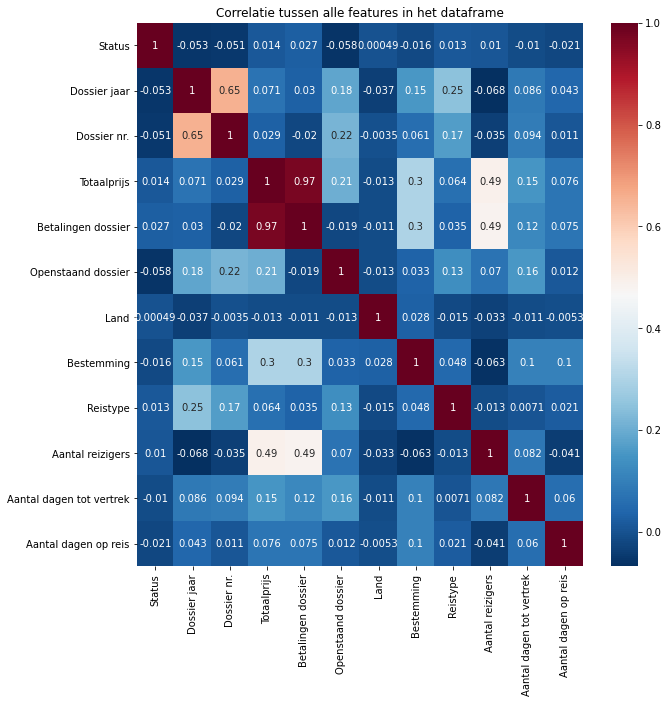

In [7]:
plt.figure(figsize=(10,10))
plt.title('Correlatie tussen alle features in het dataframe')
seaborn.heatmap((features).corr(), annot=True, cmap="RdBu_r")
plt.show();

## Selecteren van het meest interessante model

In de volgende stappen worden enkele modellen getest om te zien hoe de modellen het doen op de train en test data.

### KNN

KNN is het eenvoudigste model. Het onthoudt de trainingsgegevens en zet de te voorspellen gegevens op dezelfde grafiek. Om elk doel te voorspellen, zoekt het KNN-model het dichtstbijzijnde punt in de traingsdata en stelt de waarde van het te voorspellen gegeven in op dat van de dichtstbijzijnde buur. Er kan ingesteld worden hoeveel buren het model moet bevatten om een waarde aan het doel te geven. Meer of minder buren kiezen kan een goede of slechte invloed hebben op het classificerings model.

### Decision tree

Een decision tree is een algoritme dat gebruikmaakt van een boomachtig model om beslissingen te maken en hun mogelijke gevolgen te gaan afwegen. Het is een algoritme dat alleen voorwaardelijke controle-instructies bevat en op basis daarvan tot een voorspelling komt.

Decision trees hebben 2 hoofdzakelijke types:

* Classification tree is wanneer de voorspelde uitkomst de klasse is waartoe de gegevens behoren.
* Regression is wanneer de voorspelde uitkomst als een reëel getal kan worden beschouwd (bijvoorbeeld de prijs van een huis of de leeftijd van een persoon).

### Opsplitsen van train en test data

Onderstaande ...

In [8]:
y = features['Aantal dagen op reis'].to_numpy().astype(int)
X = features.drop(['Aantal dagen op reis', 'Klantnummer', 'Datum creatie', 'Datum vertrek', 'Datum terug'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [9]:
X

,Status,Dossier jaar,Dossier nr.,Totaalprijs,Betalingen dossier,Openstaand dossier,Land,Bestemming,Reistype,Aantal reizigers,Aantal dagen tot vertrek
0,1,2011,189,1600.00,1600.00,0.0,2,2,1,6,188
1,1,2011,190,1600.00,1600.00,0.0,2,2,1,6,188
2,1,2011,191,941.66,941.66,0.0,2,4,1,2,186
3,1,2011,192,7201.50,7201.50,0.0,2,6,1,3,246
4,1,2011,200,4291.68,4291.68,0.0,1,10,1,3,245
...,...,...,...,...,...,...,...,...,...,...,...
3960,1,2021,20210063,335.00,0.00,335.0,2,2,9,1,44
3961,1,2021,20210064,1020.00,0.00,1020.0,1,3,1,2,77
3962,1,2021,20210065,760.00,0.00,760.0,2,2,9,2,76
3963,0,2021,20210066,1076.10,0.00,1076.1,2,3,1,2,135


In [10]:
print("Shape van de data:", X.shape)
print("Shape van de target data:", y.shape)

Shape van de data: (3965, 11)
Shape van de target data: (3965,)


## modellen evalueren en vergelijken

### Het KNN-model

Onderstaande code print voor elke iteratie de train en test score uit met 4 grafieken. De twee linkse grafieken tonen het percentage per aantal neighbors op de hele trainingsset. De twee rechtse grafieken tonen het percentage per aantal neighbors op de testdata. Hieruit blijkt dat op de trainingsdata het slaagpercentage afzwakt naarmate er meer neighbors bijkomen. Wat opvalt is dat het slaagpercentage bij de testdata stijgt maar de score is wel redelijk laag (maximaal 22%).

Iteratie: 1
Accuracy on training set: 1.000
Accuracy on test set: 0.185
*-------------------------------*
Iteratie: 2
Accuracy on training set: 0.600
Accuracy on test set: 0.184
*-------------------------------*
Iteratie: 3
Accuracy on training set: 0.479
Accuracy on test set: 0.189
*-------------------------------*
Iteratie: 4
Accuracy on training set: 0.421
Accuracy on test set: 0.192
*-------------------------------*
Iteratie: 5
Accuracy on training set: 0.390
Accuracy on test set: 0.197
*-------------------------------*
Iteratie: 6
Accuracy on training set: 0.371
Accuracy on test set: 0.203
*-------------------------------*
Iteratie: 7
Accuracy on training set: 0.353
Accuracy on test set: 0.197
*-------------------------------*
Iteratie: 8
Accuracy on training set: 0.338
Accuracy on test set: 0.207
*-------------------------------*
Iteratie: 9
Accuracy on training set: 0.327
Accuracy on test set: 0.200
*-------------------------------*
Iteratie: 10
Accuracy on training set: 0.320
A

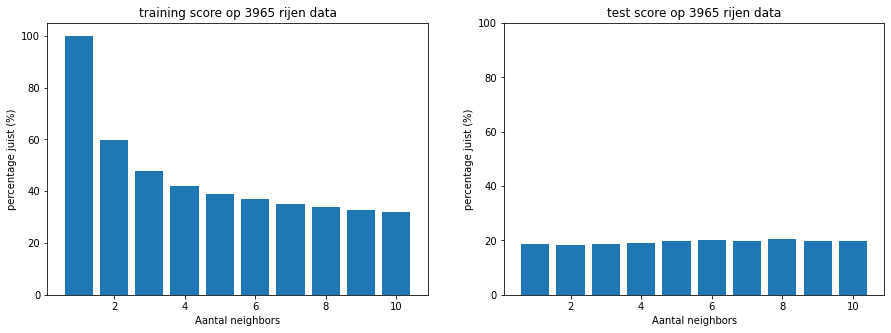

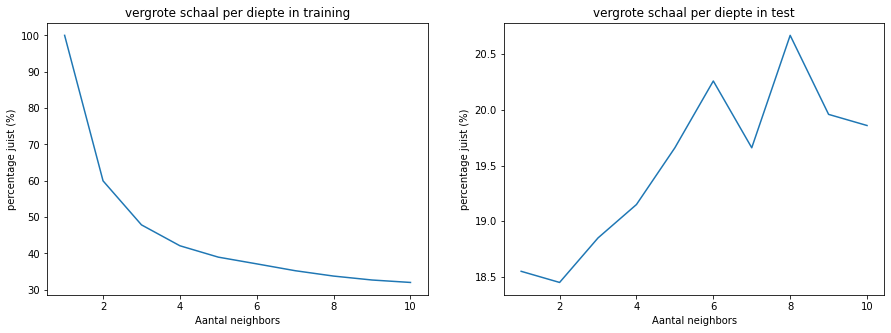

In [11]:
trainingScore = []
testScore = []
neighbors = 10

for n in range(1, neighbors + 1):
    knn = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    
    trainingScore.append(round(knn.score(X_train, y_train) * 100, 2))
    testScore.append(round(knn.score(X_test, y_test) * 100, 2))
    print("Iteratie: " + str(n))
    print("Accuracy on training set: {:.3f}".format(knn.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(knn.score(X_test, y_test)))
    print("*-------------------------------*")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
objects = range(1, neighbors + 1)

ax1.bar(objects, trainingScore, align='center')
ax1.set_title('training score op ' + str(len(X)) + ' rijen data')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('Aantal neighbors')

ax2.bar(objects, testScore, align='center')
ax2.set_ylim(0, 100)
ax2.set_title('test score op ' + str(len(X)) + ' rijen data')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('Aantal neighbors')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.plot(objects, trainingScore)
ax1.set_title('vergrote schaal per diepte in training')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('Aantal neighbors')

ax2.plot(objects, testScore)
ax2.set_title('vergrote schaal per diepte in test')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('Aantal neighbors')
plt.show()

### Het decision tree classifier systeem

Onderstaande code print voor elke iteratie de train en test score uit met 4 grafieken. De twee linkse grafieken tonen het percentage voor elke diepte op de hele trainingsset. De twee rechtse grafieken tonen het percentage van de testdata voor elke diepte. Hieruit blijkt dat op de trainingsdata het slaagpercentage toeneemt bij een hogere diepte. Op de testdata stijgt de score tot aan een diepte van 6 waarna het terug afneemt. het slaagpercentage is opnieuw niet veel hoger dan bij KNN (maximaal 30% bij decision tree).

Iteratie: 1
Accuracy on training set: 0.256
Accuracy on test set: 0.254
*-------------------------------*
Iteratie: 2
Accuracy on training set: 0.260
Accuracy on test set: 0.249
*-------------------------------*
Iteratie: 3
Accuracy on training set: 0.275
Accuracy on test set: 0.258
*-------------------------------*
Iteratie: 4
Accuracy on training set: 0.291
Accuracy on test set: 0.267
*-------------------------------*
Iteratie: 5
Accuracy on training set: 0.313
Accuracy on test set: 0.280
*-------------------------------*
Iteratie: 6
Accuracy on training set: 0.336
Accuracy on test set: 0.280
*-------------------------------*
Iteratie: 7
Accuracy on training set: 0.365
Accuracy on test set: 0.283
*-------------------------------*
Iteratie: 8
Accuracy on training set: 0.401
Accuracy on test set: 0.279
*-------------------------------*
Iteratie: 9
Accuracy on training set: 0.438
Accuracy on test set: 0.276
*-------------------------------*
Iteratie: 10
Accuracy on training set: 0.480
A

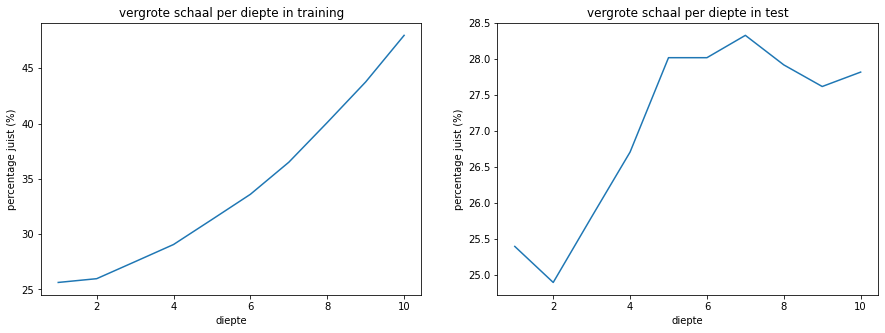

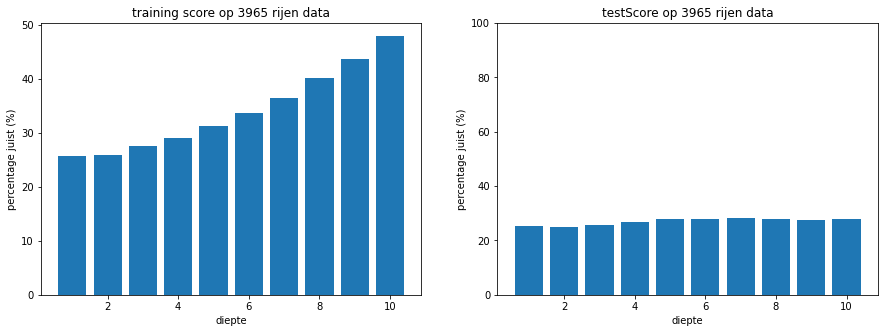

In [12]:
trainingScore = []
testScore = []
depth = 10

for n in range(1, depth + 1):
    treeModel = DecisionTreeClassifier(max_depth=n, random_state=42).fit(X_train, y_train)
    
    trainingScore.append(round(treeModel.score(X_train, y_train) * 100, 2))
    testScore.append(round(treeModel.score(X_test, y_test) * 100, 2))
    print("Iteratie: " + str(n))
    print("Accuracy on training set: {:.3f}".format(treeModel.score(X_train, y_train)))
    print("Accuracy on test set: {:.3f}".format(treeModel.score(X_test, y_test)))
    print("*-------------------------------*")
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
objects = range(1, depth + 1)

ax1.plot(objects, trainingScore)
ax1.set_title('vergrote schaal per diepte in training')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('diepte')

ax2.plot(objects, testScore)
ax2.set_title('vergrote schaal per diepte in test')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('diepte')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.bar(objects, trainingScore, align='center')
ax1.set_title('training score op ' + str(len(X)) + ' rijen data')
ax1.set_ylabel('percentage juist (%)')
ax1.set_xlabel('diepte')

ax2.bar(objects, testScore, align='center')
ax2.set_ylim(0, 100)
ax2.set_title('testScore op ' + str(len(X)) + ' rijen data')
ax2.set_ylabel('percentage juist (%)')
ax2.set_xlabel('diepte')
plt.show()

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import numpy as np

target = ['Status', 'Dossier jaar','Dossier nr.','Totaalprijs','Betalingen dossier','Openstaand dossier','Land','Bestemming','Reistype','Aantal reizigers','Aantal dagen tot vertrek']


#fig.savefig('tree.png')
#fig.savefig('DecisionTree.png')

In [14]:
logRegr = LogisticRegression(solver='liblinear', max_iter=500, multi_class = 'auto')
logRegr.fit(X_train, y_train)

print('training score: ',str(round(logRegr.score(X_train, y_train) * 100, 2)) + '%')
print('test score: ', str(round(logRegr.score(X_test, y_test) * 100, 2)) + '%')

training score:  25.09%
test score:  24.4%


### cross-validation

Cross validatie is een techniek om te beschermen tegen overfitting in een model. Bij cross validatie wordt er een vast aantal folds (of partities) van de gegevens genomen, daarop wordt de analyse uitgevoerd op elke fold en een gemiddelde van de totale foutschatting berekend.

Deze techniek wordt hieronder uitgevoerd met KNN (k-nearest neighbors), Linaire regressie en Decision tree.

In [15]:
kFold = KFold(n_splits=10, shuffle=True, random_state=42)

KNN = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train)

df_knn = pd.DataFrame(cross_validate(KNN, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(KNN, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_knn

Average cross-validation score: 0.04


/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,fit_time,score_time,test_score,train_score
0,0.013096,0.013573,0.193955,0.395460
1,0.012016,0.011598,0.236776,0.392096
2,0.012033,0.011607,0.188917,0.390695
3,0.012472,0.011820,0.229219,0.390695
4,0.012191,0.011150,0.206549,0.398262
5,0.012060,0.011162,0.179293,0.391426
6,0.012339,0.011319,0.189394,0.394228
7,0.012581,0.011632,0.196970,0.396189
8,0.012967,0.011311,0.212121,0.390025
9,0.012576,0.011309,0.219697,0.387504


In [16]:
linair = LinearRegression().fit(X_train, y_train)

df_lin = pd.DataFrame(cross_validate(linair, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(linair, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_lin

Average cross-validation score: -941431.10


,fit_time,score_time,test_score,train_score
0,0.003616,0.002081,0.037280,0.019006
1,0.002486,0.001495,0.017752,0.021318
2,0.002770,0.002631,0.022731,0.020862
3,0.002664,0.001701,0.004682,0.022750
4,0.002632,0.001347,0.026957,0.020515
5,0.002006,0.001277,0.024528,0.020484
6,0.001944,0.001210,-0.003881,0.023930
7,0.002311,0.001455,0.006428,0.022615
8,0.002148,0.001317,0.010600,0.022201
9,0.002261,0.001324,-0.004847,0.023714


In [17]:
decTree = DecisionTreeClassifier(max_depth=5, random_state=42).fit(X_train, y_train)

df_dec = pd.DataFrame(cross_validate(decTree, X, y, cv=kFold, return_train_score=True))
scores = cross_val_score(decTree, X, y)

print("Average cross-validation score: {:.2f}".format(scores.mean()))
df_dec

Average cross-validation score: 0.15


/Users/louisdhont/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


,fit_time,score_time,test_score,train_score
0,0.021428,0.001716,0.279597,0.311379
1,0.019873,0.001383,0.304786,0.310538
2,0.020068,0.001585,0.314861,0.313061
3,0.019687,0.001375,0.274559,0.310818
4,0.020339,0.001793,0.287154,0.309978
5,0.020166,0.001525,0.242424,0.319697
6,0.020146,0.001758,0.295455,0.306809
7,0.019606,0.001586,0.318182,0.308490
8,0.020146,0.001468,0.303030,0.307089
9,0.020320,0.001497,0.325758,0.305688


In [18]:
#scatter_matrix(df, figsize=(10, 10))
#plt.show()

In [19]:
#print("Average cross-validation score: {:.2f}".format(scores.mean()))